# Fama and French Factor Model #

### Import Data ###

In [1]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from functions import import_stock_universe
from capm_toolkit import compute_daily_returns
from capm_toolkit import compute_excess_returns
from portfolios_toolkit import calculate_analytics

In [4]:
# Get the important data for the Risk Free Rate

rfr = pd.read_csv(r"..\additional_data\rfr.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index, dayfirst=True)

# Get the important data for the S&P500

sp500 = pd.read_csv(r"..\additional_data\sp500.csv")
sp500 = sp500.set_index('Date')
sp500.index = pd.to_datetime(sp500.index)

# Get the data for the Stocks' Betas

betas_df = pd.read_csv(r"..\additional_data\capm_hbetas.csv")
betas_df = betas_df.set_index('date')
betas_df.index = pd.to_datetime(betas_df.index)

In [5]:
# Dictionary to store the DataFrames
folder_path = r"..\stocks"

dataframes = import_stock_universe(
    folder_path,
    ['Adjusted_close', 'Company Market Cap', 'Price_to_Book_inverse'],
    ['adj_close', 'mkt_cap', 'btp'],
)

File loaded: A (2472 rows)
File loaded: AAPL (2472 rows)
File loaded: ABBV (2472 rows)
File skipped (less than 2000 rows after cleaning): ABNB.csv
File loaded: ABT (2472 rows)
File loaded: ADBE (2472 rows)
File loaded: ADI (2472 rows)
File loaded: ADM (2472 rows)
File loaded: ADP (2472 rows)
File loaded: ADSK (2472 rows)
File loaded: AEE (2472 rows)
File loaded: AEP (2472 rows)
File loaded: AES (2472 rows)
File loaded: AFL (2472 rows)
File loaded: AIG (2472 rows)
File loaded: AIZ (2472 rows)
File loaded: AJG (2472 rows)
File loaded: AKAM (2472 rows)
File loaded: ALB (2472 rows)
File loaded: ALGN (2472 rows)
File loaded: ALL (2472 rows)
File loaded: AMAT (2472 rows)
File loaded: AMD (2472 rows)
File loaded: AME (2472 rows)
File loaded: AMGN (2472 rows)
File loaded: AMP (2472 rows)
File loaded: AMT (2472 rows)
File loaded: AMZN (2472 rows)
File loaded: ANET (2472 rows)
File loaded: ANSS (2472 rows)
File loaded: AOS (2472 rows)
File loaded: APA (2472 rows)
File loaded: APD (2472 rows)
Fil

In [6]:
# Create a whole new dataframe that contains all the stocks betas
rets_series = []

for stock, df in dataframes.items():
    series = df['adj_close'].pct_change(1).rename(stock)  
    series = series.iloc[1:]
    rets_series.append(series)

# Concat
returns_df = pd.concat(rets_series, axis=1)
returns_df = returns_df.apply(lambda x: x.fillna(x.mean()), axis=0)

# Drop nans
returns_df.dropna(inplace = True)

returns_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.018738,-0.028172,-0.018819,0.000223,-0.004976,-0.018275,-0.034602,-0.000720,-0.014614,-0.010002,...,-0.013804,0.000000,-0.017020,-0.011351,-0.027362,-0.062237,-0.020318,0.037303,-0.014077,-0.006003
2015-01-06,-0.015578,0.000094,-0.004950,-0.011356,-0.020144,-0.023384,-0.019713,-0.008350,-0.019775,-0.011641,...,-0.017107,-0.001108,-0.021331,0.005321,-0.005316,-0.005881,-0.012274,-0.008477,-0.007205,-0.009756
2015-01-07,0.013272,0.014022,0.040417,0.008108,0.008223,0.010516,0.015031,0.008784,-0.002087,0.007778,...,0.016218,0.003050,0.029368,0.008635,0.010133,0.007887,0.033138,0.024870,0.025465,0.020643
2015-01-08,0.029975,0.038422,0.010459,0.020554,0.025383,0.017655,-0.014609,0.022940,0.024747,0.003528,...,0.019657,0.010779,0.012031,0.011599,0.016645,0.007546,0.017420,0.010617,0.021359,0.015399
2015-01-09,-0.007337,0.001072,-0.027355,-0.010508,-0.014743,-0.000730,-0.008530,-0.007162,-0.009014,-0.011206,...,-0.011453,-0.001367,0.012499,-0.012285,-0.001410,-0.018863,-0.001767,-0.014424,0.014613,0.001584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,-0.024130,-0.002622,0.011901,-0.007437,-0.009242,-0.004653,-0.007839,0.001478,-0.004486,-0.005327,...,-0.002959,-0.019820,0.010471,0.003941,0.005163,-0.008678,-0.004776,-0.008935,-0.001584,0.000317
2024-10-23,-0.003222,-0.021623,-0.004662,0.007664,-0.016386,0.009928,0.007003,-0.004462,-0.007574,0.016408,...,0.000140,0.006319,-0.017304,0.010050,-0.003563,0.002664,0.004949,0.004220,-0.010511,-0.002744
2024-10-24,-0.017590,-0.000823,0.009421,-0.004017,-0.004453,0.012475,0.007489,-0.002103,-0.001834,-0.002130,...,0.154343,0.008791,0.002252,0.012282,-0.005654,-0.008123,-0.006417,-0.006686,-0.016409,-0.039632


In [7]:
# Create a whole new dataframe that contains all the stocks betas
mktcap_series = []

for stock, df in dataframes.items():
    series = df['mkt_cap'].rename(stock)  
    mktcap_series.append(series)

# Concat
mktcap_df = pd.concat(mktcap_series, axis=1)

# Apply Logs and EMA (maybe)
mktcap_df = np.log(mktcap_df)
mktcap_df = mktcap_df.ewm(span=5, adjust = False).mean()
mktcap_df = mktcap_df.bfill()
mktcap_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,23.334123,27.203970,25.377155,24.943681,24.302035,23.559815,24.159956,24.431034,23.307838,23.113587,...,22.026376,23.674862,23.438370,23.629933,26.681463,22.658517,24.193312,23.719963,22.134555,23.801148
2015-01-05,23.330158,27.195653,25.370822,24.946472,24.298677,23.556447,24.155764,24.429394,23.302185,23.112251,...,22.026955,23.675318,23.437048,23.626971,26.674995,22.637097,24.190807,23.720752,22.135051,23.799141
2015-01-06,23.322827,27.193056,25.364946,24.941162,24.293945,23.550365,24.153454,24.427646,23.298706,23.114248,...,22.031174,23.676714,23.439184,23.627682,26.669463,22.620852,24.187762,23.722008,22.143062,23.794535
2015-01-07,23.313785,27.190051,25.374236,24.935147,24.287945,23.546062,24.146133,24.425507,23.290937,23.118662,...,22.028543,23.675366,23.437905,23.631093,26.664810,22.612640,24.184353,23.718410,22.143070,23.798275
2015-01-08,23.298673,27.178876,25.383898,24.928643,24.285371,23.538298,24.139563,24.423942,23.281595,23.124659,...,22.021584,23.673826,23.434914,23.636280,26.658798,22.609671,24.178091,23.709693,22.143280,23.805863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,24.359499,28.894991,26.534050,26.021293,26.084679,25.458613,24.026839,25.488614,24.844448,23.881938,...,23.826310,23.869559,23.115062,24.304214,26.996807,24.201920,24.353951,23.773377,23.657095,25.182539
2024-10-23,24.358148,28.895857,26.532027,26.018830,26.082683,25.459665,24.028783,25.487036,24.844284,23.881549,...,23.829513,23.869051,23.115454,24.304586,26.995484,24.197550,24.355530,23.773072,23.656280,25.179429
2024-10-24,24.357247,28.896433,26.533804,26.017188,26.081352,25.460366,24.030079,25.485985,24.844175,23.881290,...,23.831649,23.868712,23.115716,24.304834,26.994603,24.191917,24.356583,23.772869,23.655737,25.163876


In [8]:
# Create a whole new dataframe that contains all the stocks betas

btp_series = []

for stock, df in dataframes.items():
    series = df['btp'].rename(stock)  
    series = series.iloc[1:]
    btp_series.append(series)

# Concat
btp_df = pd.concat(btp_series, axis=1)

# EMA
btp_df = btp_df.ewm(span=5, adjust = False).mean()
btp_df = btp_df.bfill()

btp_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,0.409533,0.178968,0.034847,0.341252,0.187557,0.279461,0.608711,0.154433,0.169972,0.613277,...,0.265244,0.333579,0.006472,0.562626,0.472326,0.327541,0.112471,0.317620,0.201647,0.063217
2015-01-06,0.411693,0.178962,0.034905,0.342558,0.188842,0.281691,0.612791,0.154867,0.171115,0.615685,...,0.266783,0.333702,0.006519,0.561633,0.473167,0.328187,0.112937,0.318525,0.202135,0.063425
2015-01-07,0.411317,0.178134,0.034490,0.342504,0.189179,0.282185,0.612446,0.154704,0.171997,0.615694,...,0.266373,0.333446,0.006488,0.559374,0.472141,0.327758,0.112030,0.316537,0.200779,0.063133
2015-01-08,0.407083,0.175405,0.034097,0.340169,0.187836,0.280877,0.615240,0.153441,0.171187,0.614978,...,0.264394,0.332091,0.006441,0.555748,0.468891,0.326656,0.110797,0.314117,0.198494,0.062622
2015-01-09,0.405243,0.173525,0.034147,0.339800,0.187865,0.280073,0.618882,0.152962,0.171161,0.616819,...,0.264080,0.331339,0.006384,0.555604,0.466942,0.328000,0.110038,0.314013,0.196040,0.062249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,0.146906,0.018688,0.020307,0.194749,0.066544,0.312777,0.830929,0.038287,0.039846,0.491149,...,0.122910,0.426315,-0.009915,0.506735,0.500787,0.319037,-0.202974,0.592813,0.170742,0.057366
2024-10-23,0.146906,0.018789,0.020347,0.194741,0.067081,0.312665,0.833559,0.038332,0.039961,0.489053,...,0.123244,0.428712,-0.009975,0.504769,0.501289,0.320428,-0.202851,0.593176,0.171548,0.057545
2024-10-24,0.146906,0.018861,0.020311,0.194736,0.067541,0.311307,0.833234,0.038388,0.040063,0.488001,...,0.120431,0.427517,-0.010007,0.501433,0.502576,0.322237,-0.203205,0.594750,0.173048,0.058460


## Create the Fama & French Portfolios ##

In [9]:
# Define the Decomposition Function
def fama_and_french_decomposition(
    target_df, 
    mktcap_df, 
    value_df
):
    # Common Indexes
    common_index = target_df.index.intersection(value_df.index).intersection(mktcap_df.index)
    
    # Reindex
    target_df = target_df.loc[common_index]
    mktcap_df = mktcap_df.loc[common_index]
    value_df = value_df.loc[common_index]

    # Initialize lists to store portfolio returns
    small_low_list, small_neutral_list, small_high_list = [], [], []
    big_low_list, big_neutral_list, big_high_list = [], [], []
    
    # Get unique quarters
    quarters = sorted(set([date.to_period('Q') for date in common_index]))
    
    # Dictionary to store quarterly classifications and weights
    quarterly_classifications = {}

    for quarter in quarters:
        # Select only the last available date of the quarter
        quarter_dates = [date for date in common_index if date.to_period('Q') == quarter]
        rebalance_date = quarter_dates[-1]  # Last day of the quarter
        
        # Size factor for rebalance date
        size_factor_df = pd.DataFrame([mktcap_df.loc[rebalance_date]], index=['mkt_cap']).T.dropna()
        
        # Value factor (P/B ratio) for rebalance date
        value_factor_df = pd.DataFrame([value_df.loc[rebalance_date]], index=['btp']).T.dropna()

        # Threshold for size
        median = size_factor_df['mkt_cap'].median()

        # Classify stocks into Low, Neutral, and High based on quantiles
        lower = value_factor_df['btp'].quantile(0.3)
        upper = value_factor_df['btp'].quantile(0.7)

        # Merge the two
        combined_df = size_factor_df.join(value_factor_df, how='inner')

        # Classify for Size
        combined_df['size_class'] = 'small'
        combined_df.loc[combined_df['mkt_cap'] > median, 'size_class'] = 'big'

        # Classify for Value
        combined_df['value_class'] = 'neutral'
        combined_df.loc[combined_df['btp'] <= lower, 'value_class'] = 'low'
        combined_df.loc[combined_df['btp'] >= upper, 'value_class'] = 'high'
        
        # Create the FF Portfolios
        combined_df['ff_class'] = combined_df['size_class'] + '_' + combined_df['value_class']
        
        # Market cap data
        market_caps_df = pd.DataFrame([mktcap_df.loc[rebalance_date]], index=['mkt_cap']).T
        
        # Assign market caps to value classes
        small_low_mktcap_df = market_caps_df.loc[combined_df[combined_df['ff_class'] == 'small_low'].index]
        small_neutral_mktcap_df = market_caps_df.loc[combined_df[combined_df['ff_class'] == 'small_neutral'].index]
        small_high_mktcap_df = market_caps_df.loc[combined_df[combined_df['ff_class'] == 'small_high'].index]
        big_low_mktcap_df = market_caps_df.loc[combined_df[combined_df['ff_class'] == 'big_low'].index]
        big_neutral_mktcap_df = market_caps_df.loc[combined_df[combined_df['ff_class'] == 'big_neutral'].index]
        big_high_mktcap_df = market_caps_df.loc[combined_df[combined_df['ff_class'] == 'big_high'].index]
        
        # Compute weights
        small_low_weights = small_low_mktcap_df['mkt_cap'] / small_low_mktcap_df['mkt_cap'].sum()
        small_neutral_weights = small_neutral_mktcap_df['mkt_cap'] / small_neutral_mktcap_df['mkt_cap'].sum()
        small_high_weights = small_high_mktcap_df['mkt_cap'] / small_high_mktcap_df['mkt_cap'].sum()
        big_low_weights = big_low_mktcap_df['mkt_cap'] / big_low_mktcap_df['mkt_cap'].sum()
        big_neutral_weights = big_neutral_mktcap_df['mkt_cap'] / big_neutral_mktcap_df['mkt_cap'].sum()
        big_high_weights = big_high_mktcap_df['mkt_cap'] / big_high_mktcap_df['mkt_cap'].sum()
        
        # Store classifications and weights
        quarterly_classifications[quarter] = {
            "small_low": small_low_weights,
            "small_neutral": small_neutral_weights,
            "small_high": small_high_weights,
            "big_low": big_low_weights, 
            "big_neutral": big_neutral_weights,
            "big_high": big_high_weights,
        }
    
    # Iterate over all available dates to compute daily returns
    for date in common_index:
        quarter_key = date.to_period('Q')  # Get quarter of the current date
        
        if quarter_key in quarterly_classifications:
            # Retrieve stored classification and weights
            small_low_weights = quarterly_classifications[quarter_key]["small_low"]
            small_neutral_weights = quarterly_classifications[quarter_key]["small_neutral"]
            small_high_weights = quarterly_classifications[quarter_key]["small_high"]
            big_low_weights = quarterly_classifications[quarter_key]["big_low"]
            big_neutral_weights = quarterly_classifications[quarter_key]["big_neutral"]
            big_high_weights = quarterly_classifications[quarter_key]["big_high"]
            
            # Retrieve daily returns
            target = pd.DataFrame([target_df.loc[date]], index=['returns']).T
            
            small_low_returns = target.reindex(small_low_weights.index).dropna()
            small_neutral_returns = target.reindex(small_neutral_weights.index).dropna()
            small_high_returns = target.reindex(small_high_weights.index).dropna()
            big_low_returns = target.reindex(big_low_weights.index).dropna()
            big_neutral_returns = target.reindex(big_neutral_weights.index).dropna()
            big_high_returns = target.reindex(big_high_weights.index).dropna()
            
            # Compute portfolio returns
            small_low_result = small_low_weights.reindex(small_low_returns.index).T @ small_low_returns
            small_neutral_result = small_neutral_weights.reindex(small_neutral_returns.index).T @ small_neutral_returns
            small_high_result = small_high_weights.reindex(small_high_returns.index).T @ small_high_returns
            big_low_result = big_low_weights.reindex(big_low_returns.index).T @ big_low_returns
            big_neutral_result = big_neutral_weights.reindex(big_neutral_returns.index).T @ big_neutral_returns
            big_high_result = big_high_weights.reindex(big_high_returns.index).T @ big_high_returns
            
            # Store results
            small_low_list.append(small_low_result.values[0] if not small_low_result.empty else None)
            small_neutral_list.append(small_neutral_result.values[0] if not small_neutral_result.empty else None)
            small_high_list.append(small_high_result.values[0] if not small_high_result.empty else None)
            big_low_list.append(big_low_result.values[0] if not big_low_result.empty else None)
            big_neutral_list.append(big_neutral_result.values[0] if not big_neutral_result.empty else None)
            big_high_list.append(big_high_result.values[0] if not big_high_result.empty else None)

    # Create final DataFrame
    ff_portfolios = pd.DataFrame({
        'small_high': small_high_list,
        'small_neutral': small_neutral_list,
        'small_low': small_low_list,
        'big_high': big_high_list,
        'big_neutral': big_neutral_list,
        'big_low': big_low_list
    }, index=common_index)
    
    return ff_portfolios

In [10]:
# Create DataFrames

ff_portfolio_returns = fama_and_french_decomposition(returns_df, mktcap_df, btp_df)

ff_portfolio_returns

,small_high,small_neutral,small_low,big_high,big_neutral,big_low
Date,,,,,,
2015-01-05,-0.019012,-0.017746,-0.010560,-0.020620,-0.014411,-0.014128
2015-01-06,-0.010823,-0.009360,-0.012624,-0.009066,-0.009635,-0.005959
2015-01-07,0.013570,0.011441,0.014359,0.009422,0.012790,0.015798
2015-01-08,0.019382,0.018421,0.020538,0.013758,0.019685,0.017557
2015-01-09,-0.007931,-0.006131,-0.005552,-0.008381,-0.008259,-0.008504
...,...,...,...,...,...,...
2024-10-22,-0.005510,-0.009641,-0.006024,0.002756,-0.001244,-0.004890
2024-10-23,-0.001117,-0.002207,-0.004345,-0.000164,-0.002913,-0.007492
2024-10-24,-0.000849,0.002290,0.004290,-0.005482,-0.001106,0.001869


In [11]:
# Check the Annualized Mean Returns

ff_portfolio_analytics = calculate_analytics(ff_portfolio_returns)

ff_portfolio_analytics

,Annualized Returns,Annualized Volatility,Sharpe Ratio,Max Drawdown,VaR 95%
small_high,0.048194,0.226708,0.212581,-0.006791,-0.020269
small_neutral,0.137929,0.189194,0.729037,-0.004491,-0.016841
small_low,0.238761,0.190093,1.256019,-0.003508,-0.017392
big_high,0.079352,0.196190,0.404462,-0.005146,-0.017798
big_neutral,0.150121,0.164786,0.911003,-0.003371,-0.015060
big_low,0.221966,0.180182,1.231901,-0.003453,-0.016206


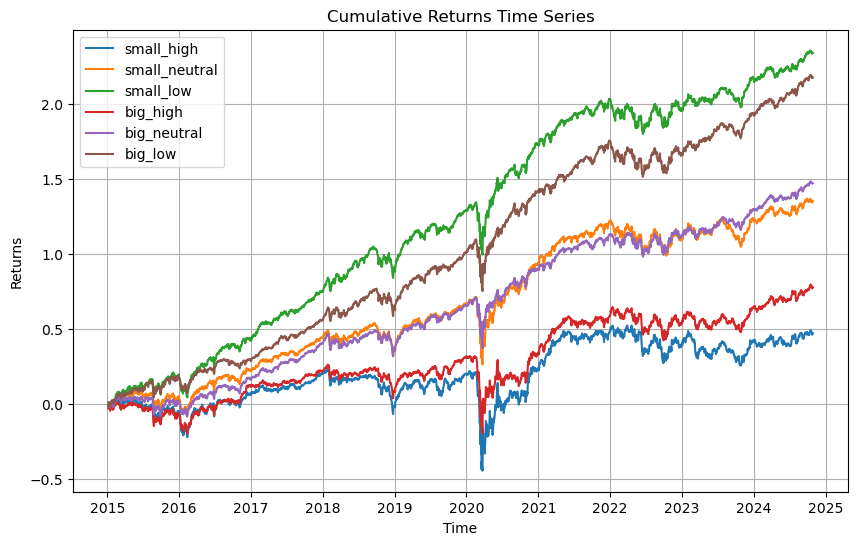

In [12]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(ff_portfolio_returns.cumsum(), label=ff_portfolio_returns.columns, alpha=1)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [13]:
# Create DataFrames

ff_portfolio_betas = fama_and_french_decomposition(betas_df, mktcap_df, btp_df)

ff_portfolio_betas

,small_high,small_neutral,small_low,big_high,big_neutral,big_low
2016-01-06,1.053647,0.959239,0.948816,0.979916,0.952021,0.942812
2016-01-07,1.036831,0.961085,0.955013,0.978633,0.953540,0.958445
2016-01-08,1.037786,0.960718,0.954604,0.977321,0.954295,0.960148
2016-01-11,1.037318,0.960245,0.953422,0.978035,0.952595,0.958249
2016-01-12,1.032296,0.958634,0.942643,0.978519,0.952495,0.958063
...,...,...,...,...,...,...
2024-10-21,0.759514,0.827990,0.742647,0.601011,0.735196,0.889842
2024-10-22,0.754587,0.825187,0.742276,0.598026,0.733023,0.888782
2024-10-23,0.744375,0.821397,0.741140,0.589527,0.729833,0.888477
2024-10-24,0.742343,0.820682,0.741329,0.587138,0.728575,0.888246


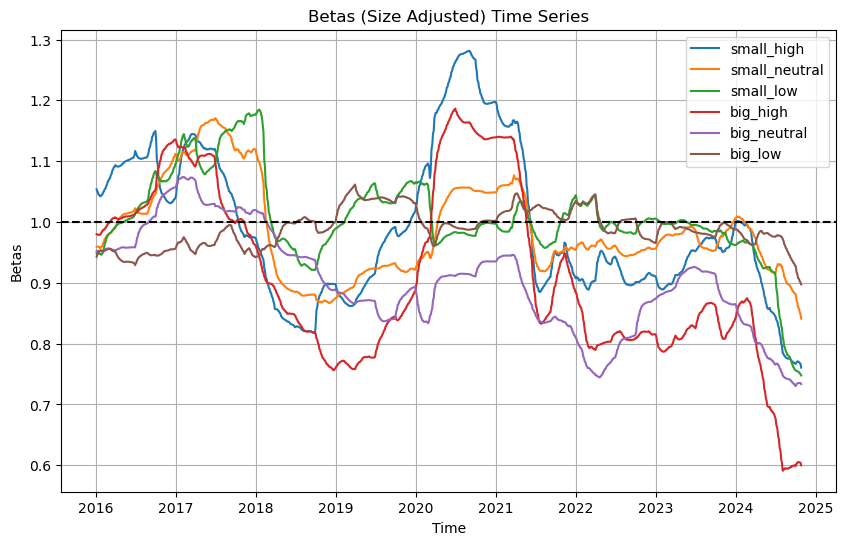

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(ff_portfolio_betas.ewm(span=21, adjust = False).mean(), label=ff_portfolio_betas.columns, alpha=1)
plt.axhline(y=1, color='black', linestyle='dashed')

# Config
plt.title('Betas (Size Adjusted) Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()
plt.grid()

# Show
plt.show()

In [16]:
# Calculate the SMB Premium

SMB = (1/3)*(ff_portfolio_returns['small_low'] + ff_portfolio_returns['small_neutral'] + ff_portfolio_returns['small_high']) \
    - (1/3)*(ff_portfolio_returns['big_low'] + ff_portfolio_returns['big_neutral'] + ff_portfolio_returns['big_high'])

SMB.name = 'SMB'
SMB

Date
2015-01-05    0.000614
2015-01-06   -0.002716
2015-01-07    0.000453
2015-01-08    0.002447
2015-01-09    0.001843
                ...   
2024-10-22   -0.005932
2024-10-23    0.000967
2024-10-24    0.003483
2024-10-25   -0.000201
2024-10-28    0.003316
Name: SMB, Length: 2471, dtype: float64

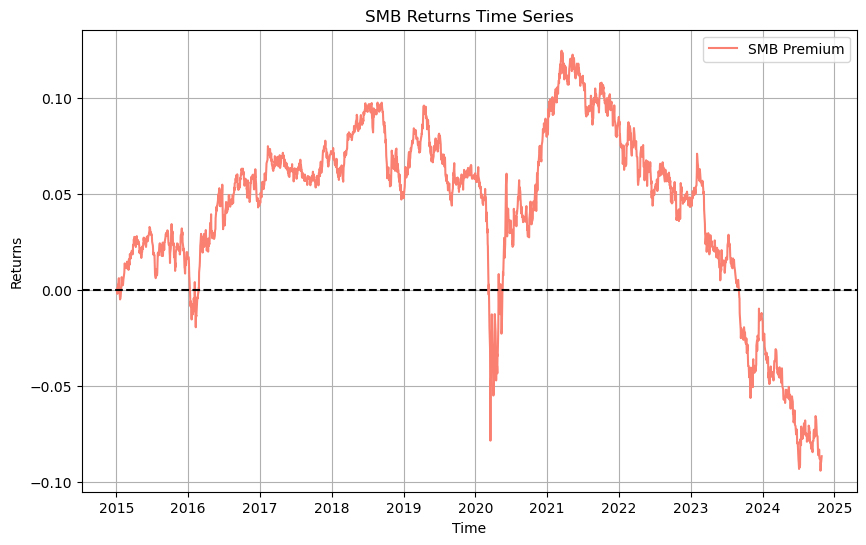

In [17]:
# Plot SMB

plt.figure(figsize=(10, 6))
plt.plot(SMB.cumsum(), label='SMB Premium', color = 'salmon', alpha=1)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('SMB Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [18]:
# Calculate the HML Premium

HML = (1/2)*(ff_portfolio_returns['small_high'] + ff_portfolio_returns['big_high']) \
    - (1/2)*(ff_portfolio_returns['small_low'] + ff_portfolio_returns['big_low'])

HML.name = 'HML'

HML 

Date
2015-01-05   -0.007472
2015-01-06   -0.000653
2015-01-07   -0.003583
2015-01-08   -0.002477
2015-01-09   -0.001128
                ...   
2024-10-22    0.004081
2024-10-23    0.005278
2024-10-24   -0.006245
2024-10-25   -0.004926
2024-10-28    0.006590
Name: HML, Length: 2471, dtype: float64

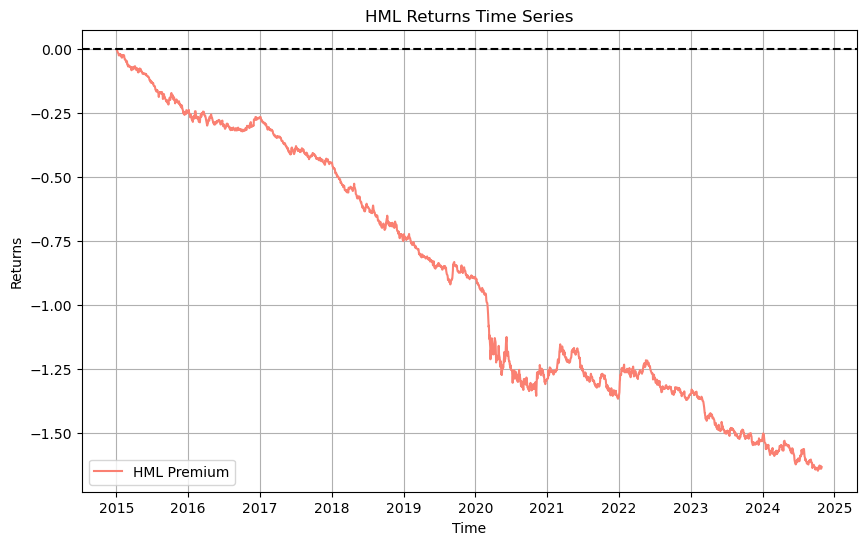

In [19]:
# Plot HML

plt.figure(figsize=(10, 6))
plt.plot(HML.cumsum(), label='HML Premium', color = 'salmon', alpha=1)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('HML Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [20]:
# Create the market data
daily_rfr = compute_daily_returns(rfr['risk_free_rate'])
market_excess_returns = compute_excess_returns(sp500['sp_500'], rfr['risk_free_rate'])

In [21]:
# Check the Correlation

print(f'SMB premium correlation  with HML premium: {SMB.corr(HML)}')
print(f'SMB premium correlation  with market premium: {SMB.corr(market_excess_returns)}')
print(f'HML premium correlation  with market premium: {HML.corr(market_excess_returns)}')

SMB premium correlation  with HML premium: 0.3285264390576796
SMB premium correlation  with market premium: 0.24288523717756552
HML premium correlation  with market premium: 0.05483925662507092


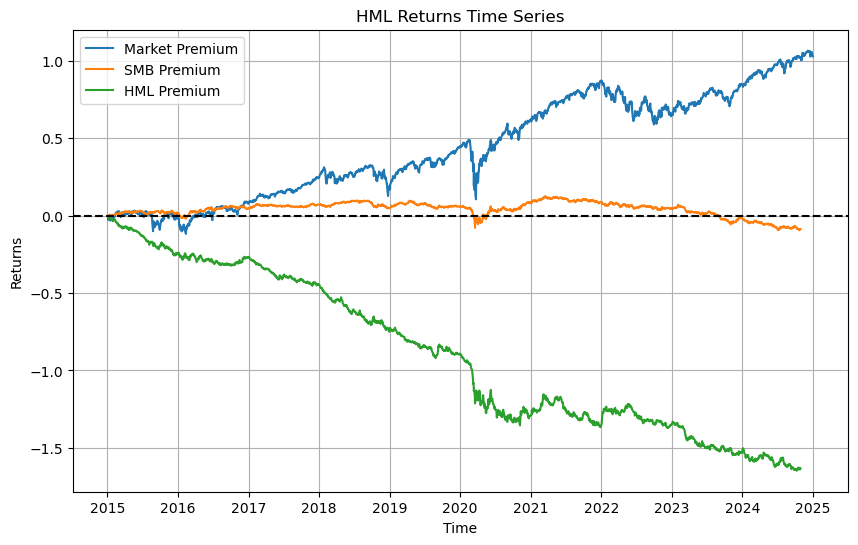

In [22]:
# Plot HML

plt.figure(figsize=(10, 6))
plt.plot(market_excess_returns.cumsum(), label='Market Premium', alpha=1)
plt.plot(SMB.cumsum(), label='SMB Premium', alpha=1)
plt.plot(HML.cumsum(), label='HML Premium', alpha=1)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('HML Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [23]:
# Store both series

SMB.to_csv(r"..\additional_data\famafrench_smb.csv")
HML.to_csv(r"..\additional_data\famafrench_hml.csv")